In [1]:
import fluid_flow_model as fl
import json
import matplotlib.pyplot as plt

In [2]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)

In [3]:
model = fl.FluidFlowModel(data_as_is['initial_demand'],
                          data_as_is['initial_capacity']['housing'],
                          data_as_is['initial_capacity']['shelter'],
                          1/data_as_is['service_mean']['housing'],
                          data_as_is['arrival_rates'],
                          data_as_is['build_rates']['housing'],
                          data_as_is['build_rates']['shelter'])

In [4]:
T=5
dt = 1/365
model.analyse_model(T, dt)

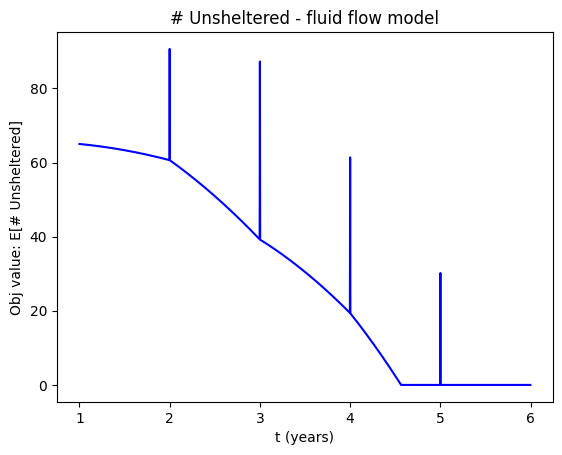

In [6]:
x = [(i+365)/365 for i in range(int(T/dt))]
plt.plot(x, model.unsh_t, color = 'blue')
plt.title('# Unsheltered - fluid flow model')
plt.xlabel('t (years)')
plt.ylabel('Obj value: E[# Unsheltered]')
plt.show()